In [17]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Downsampling block (encoder)
def downsample_block(input_layer, filters, kernel_size, padding='same', activation='relu'):
    conv1 = layers.Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer='HeNormal')(input_layer)
    # conv1 = layers.Dropout(0.1)(conv1)
    conv1 = layers.Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer='HeNormal')(conv1)
    # b1 = layers.BatchNormalization()(conv1)
    # r1 = layers.ReLU()(b1)
    r1 = layers.ReLU()(conv1)
    pool = layers.MaxPooling2D(pool_size=(2, 2))(r1)
    # print("Downsample block shape is: " ,conv1.shape)
    return conv1, pool

# Upsampling block
def upsample_block(input_layer, skip_connection, filters, kernel_size, padding='same', activation='relu'):
    up = layers.UpSampling2D(size=(2, 2))(input_layer)
    up = layers.Conv2DTranspose(filters, kernel_size, activation=activation, padding=padding)(up)
    merge = layers.concatenate([up, skip_connection], axis=3)
    conv = layers.Conv2D(filters, 3, activation=activation, padding=padding, kernel_initializer='HeNormal')(merge)
    conv = layers.Conv2D(filters, 3, activation=activation, padding=padding, kernel_initializer='HeNormal')(conv)
    # print("upsample block shape is: " ,conv.shape)
    return conv

# Define the U-Net architecture
def unet(input_shape):
    inputs = tf.keras.Input(input_shape)

    conv1, pool1 = downsample_block(inputs, 64, (3, 3))
    conv2, pool2 = downsample_block(pool1, 128, (3, 3))
    # conv3, pool3 = downsample_block(pool2, 256, (3, 3))
    # conv4, pool4 = downsample_block(pool3, 512, (3, 3))

    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(pool2)
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # conv6 = upsample_block(conv5, conv4, 512, (3, 3))
    # conv7 = upsample_block(conv6, conv3, 256, (3, 3))
    conv8 = upsample_block(conv5, conv2, 128, (3, 3))
    conv9 = upsample_block(conv8, conv1, 64, (3, 3))

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [164]:
import numpy as np
import os


# getting the maximum shape of the numpy array

def get_max_shape(dir):
    max_y = 0
    max_x = 0
    for filename in os.listdir(dir):
        if filename.endswith(".npy"):
            file_path = os.path.join(dir, filename)

            # Load the .npy file and append it to the x_train list
            spectrogram = np.load(file_path)
            if spectrogram.shape[1] > max_y:
                max_y = spectrogram.shape[1]

            if spectrogram.shape[0] > max_x:
                max_x = spectrogram.shape[0]

    return (max_x, max_y)

def get_array(dir, final_shape):
    # Initialize an empty list to store the loaded spectrograms
    arr = []
    # Get the list of files in the directory and sort them alphabetically
    file_list = sorted(os.listdir(dir))
    # Iterate through each file in the directory
    for filename in file_list:
        if filename.endswith(".npy"):
            file_path = os.path.join(dir, filename)
            print(file_path)

            # Load the .npy file and append it to the x_train list
            spectrogram = np.load(file_path)
            # Pad the spectrogram to match the desired final shape
            if spectrogram.shape[1] < final_shape[1]:
                # Pad the spectrogram to match the desired final shape
                pad_width = ((0, 0), (0, final_shape[1] - spectrogram.shape[1]))
                processed_spectrogram = np.pad(spectrogram, pad_width, mode='constant', constant_values=0)
            elif spectrogram.shape[1] > final_shape[1]:
                # Trim the spectrogram to match the desired final shape
                processed_spectrogram = spectrogram[:final_shape[0], :final_shape[1]]
            else:
                processed_spectrogram = spectrogram  # No change needed if the shape is already as desired
            # Append the padded spectrogram to the x_train list
            processed_spectrogram = processed_spectrogram[:final_shape[0], :]
            arr.append(processed_spectrogram)

    # Convert the list to a NumPy array if required
    arr = np.array(arr)

    return arr

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

In [165]:
x_train_dir = '/content/drive/MyDrive/Colab Notebooks/speech denoiser/x_train_noised_speech'
y_train_dir = '/content/drive/MyDrive/Colab Notebooks/speech denoiser/y_train_clean_audio'

shape = get_max_shape(x_train_dir)

In [6]:
shape

(257, 496)

In [166]:
shape = (256, 128)
x_train = get_array(dir= x_train_dir, final_shape=shape)
y_train = get_array(dir=y_train_dir, final_shape=shape)

/content/drive/MyDrive/Colab Notebooks/speech denoiser/x_train_noised_speech/p234_001.wav_spec.npy
/content/drive/MyDrive/Colab Notebooks/speech denoiser/x_train_noised_speech/p234_002.wav_spec.npy
/content/drive/MyDrive/Colab Notebooks/speech denoiser/x_train_noised_speech/p234_003.wav_spec.npy
/content/drive/MyDrive/Colab Notebooks/speech denoiser/x_train_noised_speech/p234_004.wav_spec.npy
/content/drive/MyDrive/Colab Notebooks/speech denoiser/x_train_noised_speech/p234_005.wav_spec.npy
/content/drive/MyDrive/Colab Notebooks/speech denoiser/x_train_noised_speech/p234_006.wav_spec.npy
/content/drive/MyDrive/Colab Notebooks/speech denoiser/x_train_noised_speech/p234_007.wav_spec.npy
/content/drive/MyDrive/Colab Notebooks/speech denoiser/x_train_noised_speech/p234_008.wav_spec.npy
/content/drive/MyDrive/Colab Notebooks/speech denoiser/x_train_noised_speech/p234_009.wav_spec.npy
/content/drive/MyDrive/Colab Notebooks/speech denoiser/x_train_noised_speech/p234_010.wav_spec.npy
/content/d

In [8]:
y_train.shape

(29, 256, 128)

In [9]:
# reshaping to make it suitable for training
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1 )
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 1 )

In [10]:
model = unet(input_shape=x_train.shape[1:])

In [11]:
# mae = tf.keras.losses.MeanAbsoluteError()
binary_loss = tf.keras.losses.BinaryCrossentropy()
# sparse_loss=tf.keras.losses.SparseCategoricalCrossentropy()

# adam = tf.keras.optimizers.Adam(learning_rate=0.1)

# implemeting callbacks


In [42]:
# from keras.callbacks import *
# filepath = "/content/grive/My Drive/Colab Notebooks/speech denoiser/training/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

import keras
import warnings

class IoUCheckpoint(keras.callbacks.Callback):
    def __init__(self, filepath, monitor='iou', verbose=1, save_best_only=True, mode='max'):
        super(IoUCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.mode = mode
        self.best_iou = -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current_iou = logs.get(self.monitor)
        if current_iou is None:
            warnings.warn(f'Cannot save best model. {self.monitor} is not available.', RuntimeWarning)
        else:
            if current_iou > self.best_iou:
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: {self.monitor} improved from {self.best_iou} to {current_iou}.")
                self.best_iou = current_iou
                if self.save_best_only:
                    # file_path = self.filepath.format(epoch=epoch + 1, iou=current_iou)
                    self.model.save_weights(self.filepath, overwrite = True)
                    if self.verbose > 0:
                        print(f"\nSaved best model based on {self.monitor} to {self.filepath}")

# Example usage:
filepath = "/content/drive/My Drive/Colab Notebooks/speech denoiser/training/best_weight.hdf5"
iou_checkpoint = IoUCheckpoint(filepath=filepath, monitor='iou', verbose=1, save_best_only=True)

# Add the callback to the list of callbacks during model training
callbacks = [iou_checkpoint]


In [24]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# # Define a callback to save the model after every 10 epochs
# checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/speech denoiser/training/model_checkpoint_{epoch:02d}.h5',
#                              save_weights_only=True,
#                              save_freq=10)


In [13]:
# Define the IoU metric function
def iou(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3]) - intersection
    iou_score = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
    return iou_score

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

model = unet(input_shape=x_train.shape[1:])
model.compile(optimizer=adam, loss=binary_loss, metrics=[iou])

history = model.fit(
    x_train, y_train,
    batch_size= 3,
    epochs=100,
    callbacks = callbacks,
)

In [ ]:
from keras import backend as K

# loding the saved model
saved_model = '/content/drive/MyDrive/Colab Notebooks/speech denoiser/training/best_weight.hdf5'
model.load_weights(saved_model)



# # To get learning rate
# print(K.get_value(model.optimizer.lr))

# # To set learning rate
# K.set_value(model.optimizer.lr, 0.0001)

In [55]:
print(K.get_value(model.optimizer.lr))

0.001


In [60]:
history1 = model.fit(
    x_train, y_train,
    batch_size= 3,
    epochs=2000,
    callbacks = callbacks,
)

Epoch 1/2000
 6/10 [=================>............] - ETA: 0s - loss: 0.4572 - iou: 0.2961

10/10 [==============================] - 1s 132ms/step - loss: 0.4523 - iou: 0.2977
Epoch 2/2000
10/10 [==============================] - ETA: 0s - loss: 0.4523 - iou: 0.2983
Epoch 2: iou improved from 0.29830774664878845 to 0.29831019043922424.

Saved best model based on iou to /content/drive/My Drive/Colab Notebooks/speech denoiser/training/best_weight.hdf5
10/10 [==============================] - 2s 179ms/step - loss: 0.4523 - iou: 0.2983
Epoch 3/2000
10/10 [==============================] - 1s 131ms/step - loss: 0.4523 - iou: 0.2968
Epoch 4/2000
10/10 [==============================] - 1s 131ms/step - loss: 0.4524 - iou: 0.2971
Epoch 5/2000
10/10 [==============================] - 1s 132ms/step - loss: 0.4523 - iou: 0.2982
Epoch 6/2000
10/10 [==============================] - 1s 132ms/step - loss: 0.4524 - iou: 0.2972
Epoch 7/2000
10/10 [==============================] - 1s 133ms/step - loss: 0.4524 - iou: 0.2980
Epoch 8/2000
10/10 [==============================] - 1s 134ms/step -

KeyboardInterrupt: ignored

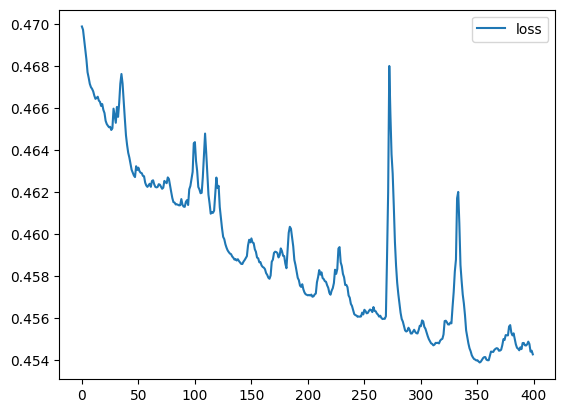

In [65]:
import matplotlib.pyplot as plt
plt.plot(history1.history['loss'],label="loss")
# plt.plot(history1.history['val_loss'],label="validation loss")
plt.legend()
plt.show()

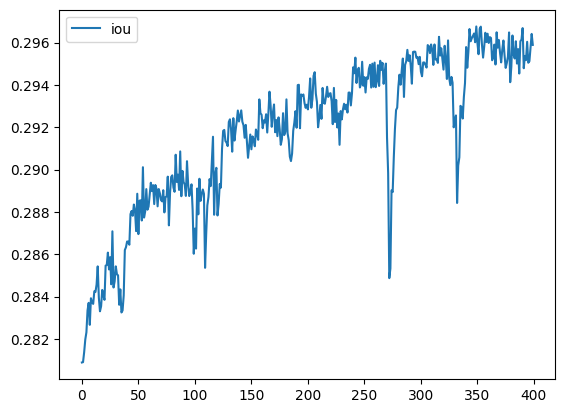

In [66]:
plt.plot(history1.history['iou'],label="iou")
# plt.plot(history1.history['val_loss'],label="validation loss")
plt.legend()
plt.show()

In [151]:
pred = model.predict(x_train)
original = x_train

1/1 [==============================] - 0s 40ms/step


In [93]:
pred.shape

(29, 256, 128, 1)

In [152]:
pred = pred.reshape(pred.shape[0], pred.shape[1], pred.shape[2])
original = original.reshape(original.shape[0], original.shape[1], original.shape[2])
pred.shape

(29, 256, 128)

In [95]:
import librosa
import librosa.display
import IPython.display as ipd
from glob import glob

import soundfile as sf
import pickle

In [ ]:
file_path = 'min_max_values.pkl'
with open(file_path, 'rb') as f:
        min_max_values = pickle.load(f)
min_max_values

In [97]:
# constants
HOP_LENGTH = 256
MONO = 22050
SAMPLE_RATE = 16000
FRAME_SIZE = 512
OVERLAP_RATIO=0.3

In [126]:
spec_path = 'x_train_noised_speech\p234_002.wav_spec.npy'

In [127]:
# 2. Obtain the corresponding min max value of the loaded spectrogram
def get_min_max_values(file_path, min_max_values):
    min_val = min_max_values[file_path]['min']
    max_val = min_max_values[file_path]['max']
    return min_val, max_val

def denormalize(spectrogram, min_val, max_val):
    denormalized_spectrogram = spectrogram * (max_val - min_val) + min_val
    return denormalized_spectrogram

# 4. Convert spectrogram to audio signal
def spectrogram_to_audio(spectrogram):
    spectrogram = librosa.db_to_amplitude(spectrogram)
    audio_signal = librosa.istft(spectrogram, hop_length=HOP_LENGTH)
    return audio_signal

In [156]:
min_val, max_val = get_min_max_values(spec_path, min_max_values)
denorm_spectrogram =denormalize(pred[1], min_val, max_val)
audio = spectrogram_to_audio(denorm_spectrogram)
audio

array([ 7.2160223e-04,  6.9023634e-04,  6.5239426e-04, ...,
       -6.1767660e-11,  3.3953333e-11,  1.4084175e-10], dtype=float32)

In [157]:
sf.write('constructed.wav', audio, samplerate= SAMPLE_RATE)
constructed_audio = glob('*.wav')
constructed_audio

['original_constructed.wav', 'constructed.wav']

In [158]:
ipd.Audio(constructed_audio[1])

In [159]:
min_val, max_val = get_min_max_values(spec_path, min_max_values)
denorm_spectrogram =denormalize(original[1], min_val, max_val)
audio = spectrogram_to_audio(denorm_spectrogram)

sf.write('original_constructed.wav', audio, samplerate= SAMPLE_RATE)
constructed_audio = glob('*.wav')
constructed_audio

['original_constructed.wav', 'constructed.wav']

In [160]:
ipd.Audio(constructed_audio[0])